### Download data from github

In [1]:
!nvidia-smi

Mon Aug 26 23:46:33 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:

!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25 (from 1)
Receiving objects: 100% (39/39), 177.08 MiB | 18.43 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.


In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-08-26 23:46:47--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-08-26 23:46:47 (79.1 MB/s) - ‘helper_functions.py’ saved [10246/10246]



### Importing all necessary libraries

In [4]:
import os
import tensorflow as tf
import pandas as pd
import tensorflow_hub as hub
import string
import numpy as np

from helper_functions import *
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from keras.utils import plot_model
from tensorflow.keras import mixed_precision


### Becoming one with data

In [43]:
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

#### Preprocess data

In [44]:
def read_lines(filepath):
    """
    Reads filepath and returns the lines of text as a list

    Args:
      filepath: a string representing the target file

    Returns:
      A list of string
    """

    with open(filepath, "r") as f:
      return f.readlines()

In [45]:
read_lines(filenames[0])

['###24845963\n',
 'BACKGROUND\tThis study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( ADHF ) .\n',
 'RESULTS\tA post hoc analysis was conducted with the use of data from the Evaluation Study of Congestive Heart Failure and Pulmonary Artery Catheterization Effectiveness ( ESCAPE ) .\n',
 'RESULTS\tLiver function tests ( LFTs ) were measured at @ time points from baseline , at discharge , and up to @ months follow-up .\n',
 'RESULTS\tSurvival analyses were used to assess the association between admission Model of End-Stage Liver Disease Excluding International Normalized Ratio ( MELD-XI ) scores and patient outcome.There was a high prevalence of abnormal baseline ( admission ) LFTs ( albumin @ % , aspartate transaminase @ % , alanine transaminase @ % , and total bilirubin @ % ) .\n',
 "RESULTS\tThe percentage of patients with abnormal LFTs decreased significantly from baseline to @-months ' follow-up .\n",
 'RE

In [46]:
def preprocess_text_with_line_numbers(filepath):
  """
  Returns a list of dictionaries of abstract line data.

  Takes in filename, reads it contents and sorts through each line, extracting things like the target label,
  the text of the sentence, how many sentences are in the current abstract and what sentence number the target line is.
  """
  print(filepath)
  input_lines = read_lines(filepath) # Get all lines from filename
  abstract_lines = ""
  abstract_samples = [] # Create an empty list of abstracts

  # Loop through each line
  for i in input_lines:

    if i.startswith("###"):
      abstract_id = i
      abstract_lines = ""

    elif i.isspace(): # check if a line is a new abstract
      abstract_line_split = abstract_lines.splitlines()

      # Iterate through each line in a single abstract
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split("\t") # split target from text, because the target is separate from text by \t
        line_data["target"] = target_text_split[0]
        line_data["text"] = target_text_split[1].lower()
        line_data["line_number"] = abstract_line_number
        line_data["total_line"] = len(abstract_line_split) - 1
        abstract_samples.append(line_data)

    else: # If the above conditions aren't fulfilled, the line contains a labelled sentence
        abstract_lines += i

  return abstract_samples

In [47]:
%%time
train_samples = preprocess_text_with_line_numbers('pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt')
test_samples = preprocess_text_with_line_numbers('pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt')
val_samples = preprocess_text_with_line_numbers('pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt')

pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt
pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt
pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt
CPU times: user 738 ms, sys: 90.1 ms, total: 828 ms
Wall time: 912 ms


In [48]:
len(train_samples), len(test_samples), len(val_samples)

(180040, 30135, 30212)

In [49]:
train_samples[:5]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_line': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_line': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_line': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_line': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontario an

In [50]:
train_df = pd.DataFrame(train_samples)
test_df = pd.DataFrame(test_samples)
val_df = pd.DataFrame(val_samples)

In [51]:
train_df.head(5)

,target,text,line_number,total_line
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [52]:
# Check the distribution of labels in training data
train_df.target.value_counts()

,count
target,
METHODS,59353
RESULTS,57953
CONCLUSIONS,27168
BACKGROUND,21727
OBJECTIVE,13839


In [53]:
train_sentences = train_df.text.tolist()
val_sentences = val_df.text.tolist()
test_sentences = test_df.text.tolist()

In [54]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1, 1)) # Only use transform because it will ensure the outputs of val_df is the same as train_df\
test_labels_one_hot = one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1, 1))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [55]:
# Extract labels ("target" columns) and encoder them into integer

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.fit_transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.fit_transform(test_df['target'].to_numpy())


In [56]:
# Use tensorflow onehot encoded on total_line feature
train_total_line_one_hot = tf.one_hot(train_df["total_line"].to_numpy(),
                                      depth = 20 # percentile
                                      )
val_total_line_one_hot = tf.one_hot(val_df["total_line"].to_numpy(),
                                      depth = 20 # percentile
                                      )
test_total_line_one_hot = tf.one_hot(test_df["total_line"].to_numpy(),
                                      depth = 20 # percentile
                                      )

In [57]:
# Use tensorflow onehot encoded on total_line feature
train_line_number_one_hot = tf.one_hot(train_df["line_number"].to_numpy(),
                                      depth = 15 # percentile
                                      )
val_line_number_one_hot = tf.one_hot(val_df["line_number"].to_numpy(),
                                      depth = 15 # percentile
                                      )
test_line_number_one_hot = tf.one_hot(test_df["line_number"].to_numpy(),
                                      depth = 15 # percentile
                                      )

In [58]:
def split_chars(text):
  return " ".join(list(text))

# Text splitting word-level sequence into characters-level
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

In [59]:
alphabet = string.ascii_lowercase + string.digits + string.punctuation
max_vocab_character_size = len(alphabet)

char_len = [len(sentence) for sentence in train_sentences]
output_seq_char_len = int(np.percentile(char_len, 95))

char_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens = max_vocab_character_size,
    output_sequence_length = output_seq_char_len,
    # standardize = "lower_and_strip_punctuation",
    # output_mode = "int",
    # pad_to_max_tokens = True,
)

In [60]:
char_vectorizer.adapt(train_chars)
char_vocab = char_vectorizer.get_vocabulary()

In [61]:
# Create efficient data pipepline
train_tribrid_data = tf.data.Dataset.from_tensor_slices(
    (train_sentences, train_chars, train_line_number_one_hot, train_total_line_one_hot)
)
train_tribrid_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_tribrid_dataset = tf.data.Dataset.zip(train_tribrid_data, train_tribrid_labels) # Concatenate data and labels
train_tribrid_dataset = train_tribrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

test_tribrid_data = tf.data.Dataset.from_tensor_slices(
    (test_sentences, test_chars, test_line_number_one_hot, test_total_line_one_hot)
)
test_tribrid_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_tribrid_dataset = tf.data.Dataset.zip(test_tribrid_data, test_tribrid_labels) # Concatenate data and labels
test_tribrid_dataset = test_tribrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_tribrid_data = tf.data.Dataset.from_tensor_slices(
    (val_sentences, val_chars, val_line_number_one_hot, val_total_line_one_hot)
)
val_tribrid_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_tribrid_dataset = tf.data.Dataset.zip(val_tribrid_data, val_tribrid_labels) # Concatenate data and labels
val_tribrid_dataset = val_tribrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [62]:
num_classes = len(label_encoder.classes_)

### Build Model

#### Model 1: Triple embedding model

In [ ]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
tf_hub_embedding = hub.KerasLayer(module_url,
                                  trainable=False,
                                  input_shape=[], # Set this to empty so that it can takes input of any variable length, however the output is always of length 512
                                  dtype=tf.string,)

class UniversalSetenceEncoder(tf.keras.Layer):
    def call(self, x):
        print(tf_hub_embedding(x))
        return tf_hub_embedding(x)

In [ ]:
char_embedding = tf.keras.layers.Embedding(
    input_dim = len(char_vocab),
    output_dim = 25, # This is the size of the char of embedding in paper (Figure 1)
    mask_zero = False
)

In [ ]:
# 1. Token inputs
token_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string, name="TokenInputLayer")
tokenized_inputs = UniversalSetenceEncoder(name="USEEncoder")(token_inputs)
token_outputs = tf.keras.layers.Dense(128, activation = "relu", name="TokenOutputLayer")(tokenized_inputs)
token_model = tf.keras.Model(token_inputs, token_outputs)

# 2. Char inputs
char_inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name="CharInputLayer")
tokenized_char_inputs = char_vectorizer(char_inputs)
embed_tokenized_char_inputs = char_embedding(tokenized_char_inputs)
char_outputs = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24))(embed_tokenized_char_inputs)
char_model = tf.keras.Model(char_inputs, char_outputs)

# 3. "line-number" inputs
# inputs, shape = ?
# outputs dense layer with 32 units & relu activation
line_number_inputs = tf.keras.layers.Input(shape=(15,), dtype=tf.float32, name="LineNumberInputLayer")
line_number_outputs = tf.keras.layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs, line_number_outputs)

# 4. "total-line" inputs
# inputs, shape = ?
# outputs dense layer with 32 units & relu activation
total_line_inputs = tf.keras.layers.Input(shape=(20,), dtype=tf.float32, name="TotalLineInputLayer")
total_line_outputs = tf.keras.layers.Dense(32, activation="relu")(total_line_inputs)
total_line_model = tf.keras.Model(total_line_inputs, total_line_outputs)

# 5. Hybrid embedding
combined_char_token = tf.keras.layers.Concatenate(name="token_char_hybrid")([token_model.output, char_model.output])
z = tf.keras.layers.Dropout(0.5)(combined_char_token)
z = tf.keras.layers.Dense(128, activation="relu")(z)

# 6. Tribrid embedding
combined_all = tf.keras.layers.Concatenate(name="tribrid_embed")([line_number_model.output, total_line_model.output, z])
outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(combined_all)

# 7, 8. Combine everything
model_5 = tf.keras.Model(inputs=[token_model.input, char_model.input, line_number_model.input, total_line_model.input], outputs=outputs)

Tensor("keras_layer/StatefulPartitionedCall:0", shape=(None, 512), dtype=float32)


In [ ]:
model_5.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

model_5.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ CharInputLayer            │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ TokenInputLayer           │ (None)                 │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ text_vectorization        │ (None, 290)            │              0 │ CharInputLayer[0][0]   │
│ (TextVectorization)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ USEEncoder                │ (None, 512)            │              0 │ TokenInputLayer[0][0]  │
│ (UniversalSetenceEncoder) │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 290, 25)        │            700 │ text_vectorization[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ TokenOutputLayer (Dense)  │ (None, 128)            │         65,664 │ USEEncoder[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 48)             │          9,600 │ embedding[0][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_char_hybrid         │ (None, 176)            │              0 │ TokenOutputLayer[0][0… │
│ (Concatenate)             │                        │                │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ LineNumberInputLayer      │ (None, 15)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ TotalLineInputLayer       │ (None, 20)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 176)            │              0 │ token_char_hybrid[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 32)             │            512 │ LineNumberInputLayer[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 32)             │            672 │ TotalLineInputLayer[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 128)            │         22,656 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ tribrid_embed             │ (None, 192)            │              0 │ dense[0][0],           │
│ (Concatenate)             │                        │                │ dense_1[0][0],         │
│                      

 Total params: 100,769 (393.63 KB)

 Trainable params: 100,769 (393.63 KB)

 Non-trainable params: 0 (0.00 B)

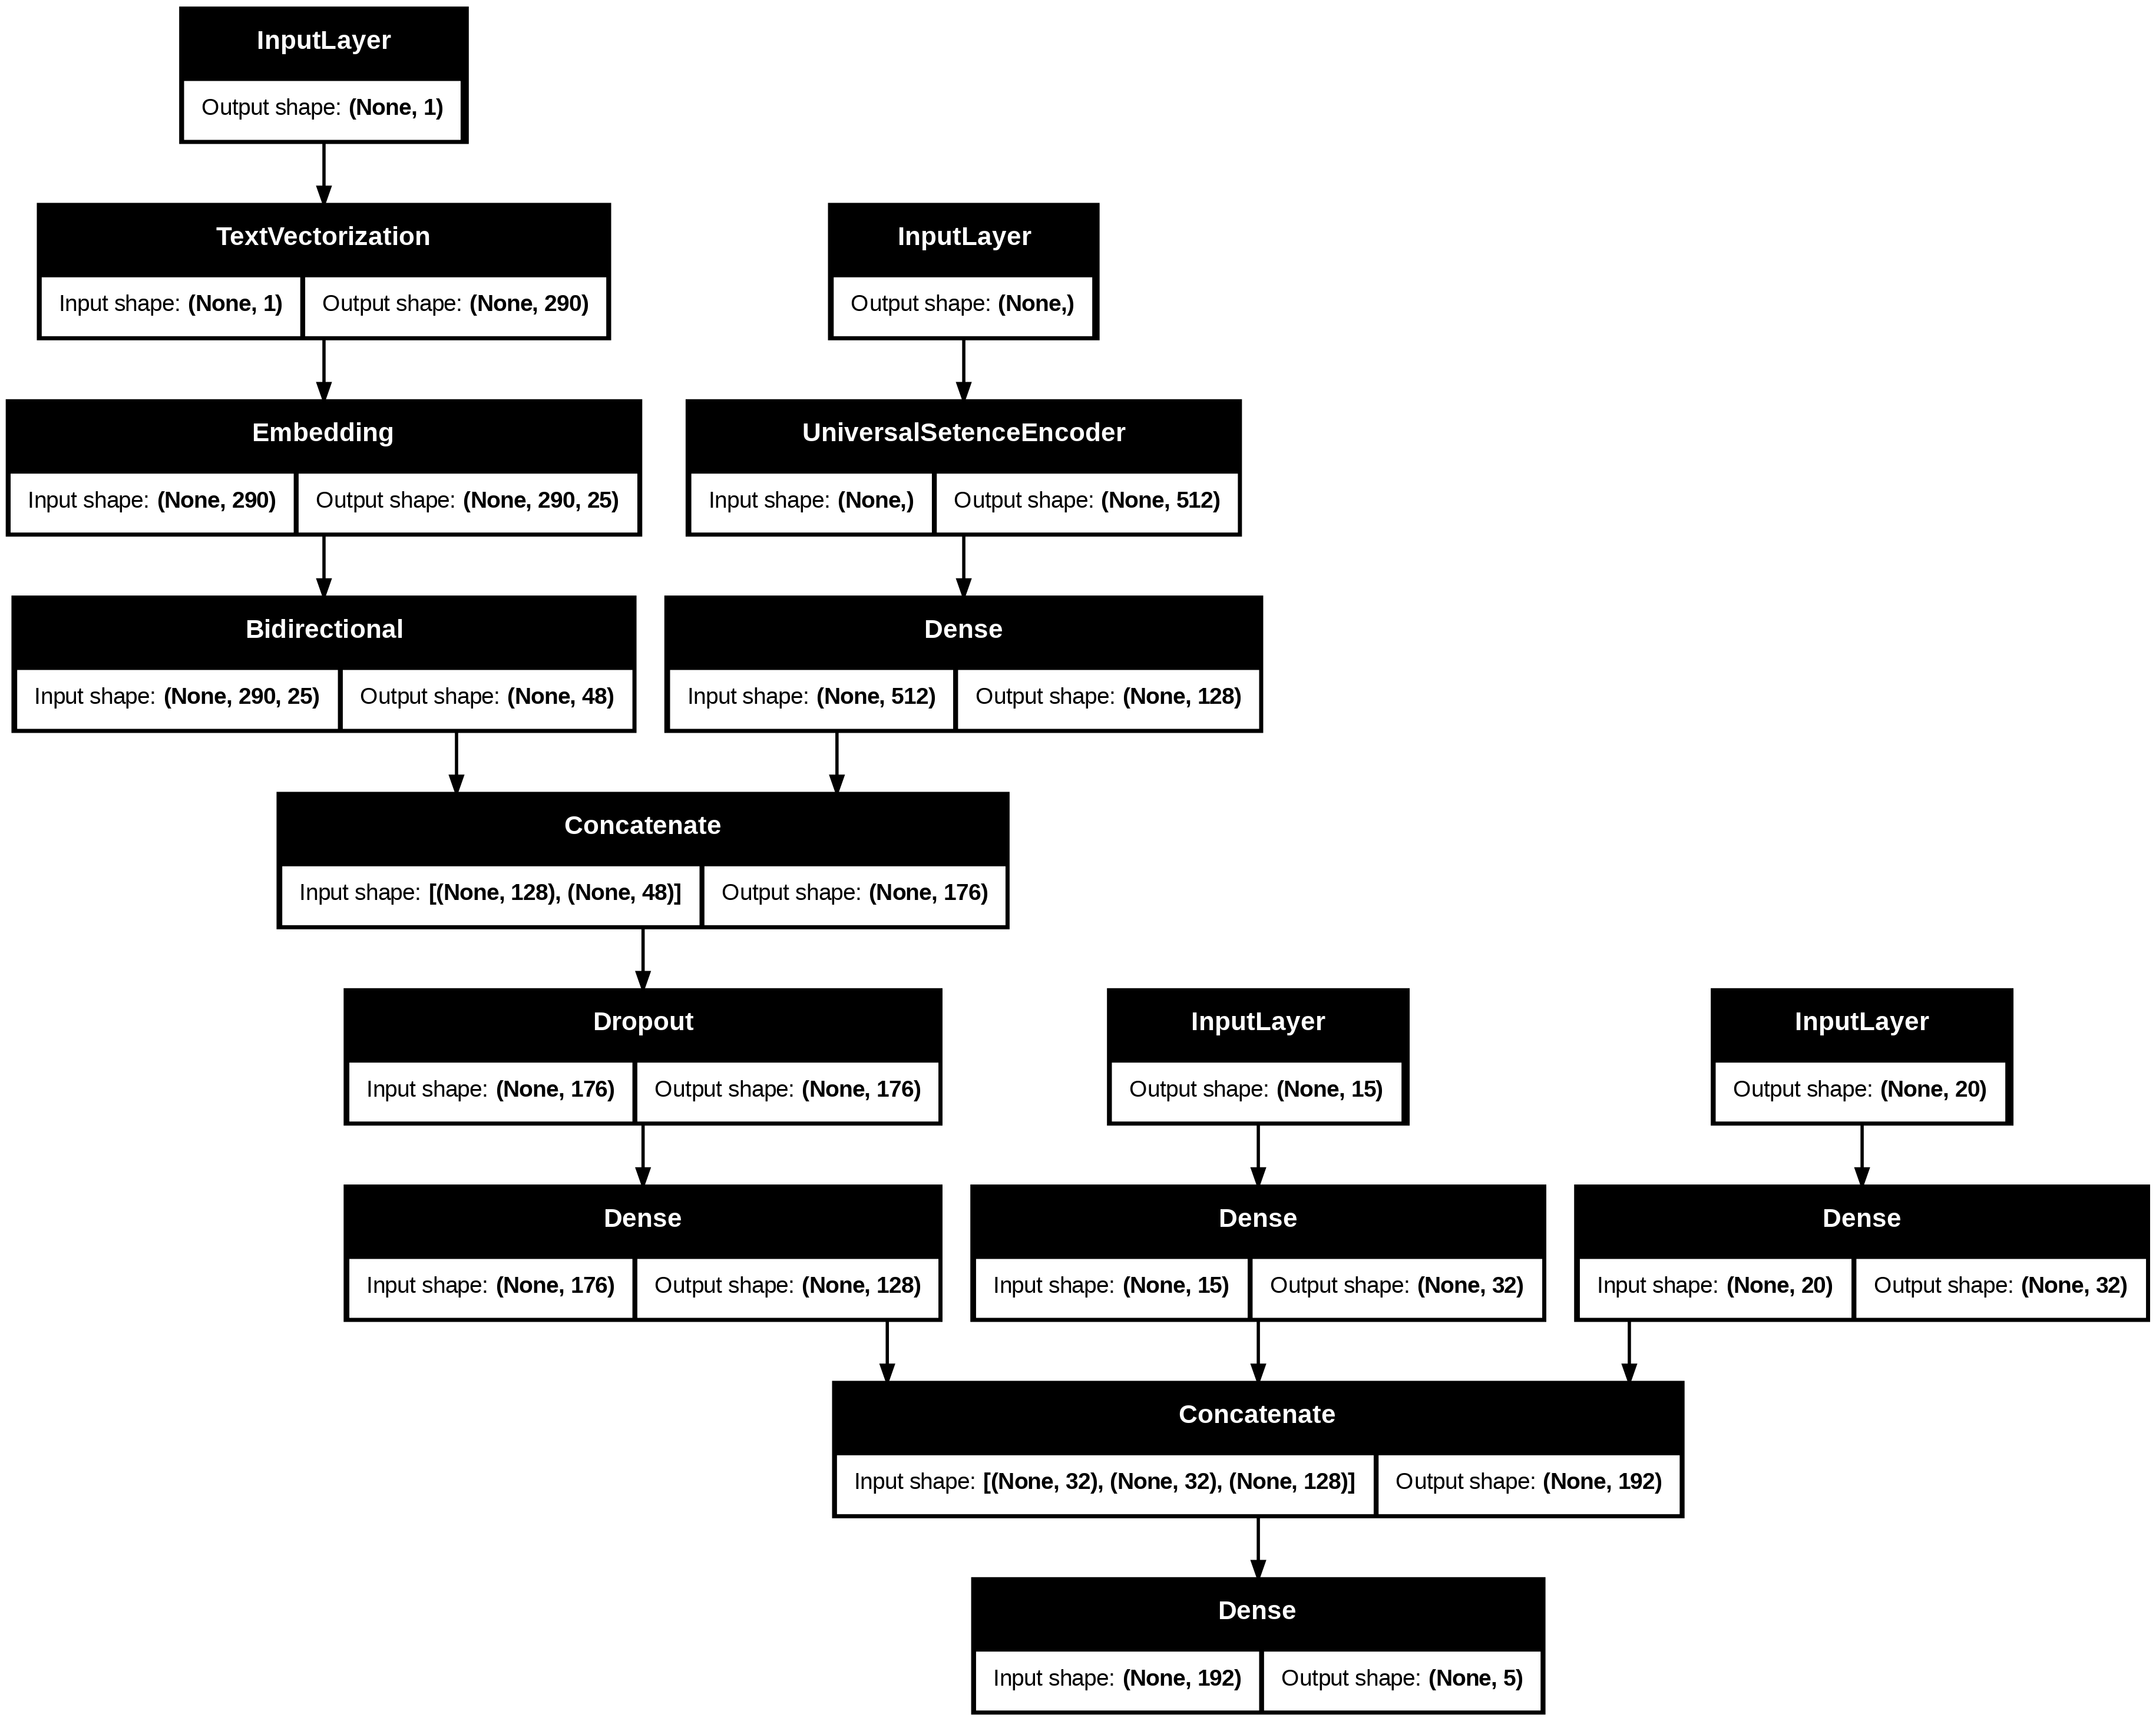

In [ ]:
plot_model(model_5, show_shapes=True)

##### Create callback functions (ModelCheckpoint, EarlyStopping)

In [ ]:
# Create a model checkpoint that:
# monitor: val_loss
# save best only
# only save weights
model_checkpoint_path = "Tribrid_model.weights.h5"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    model_checkpoint_path,
    monitor = "val_loss",
    save_best_only = True,
    save_weights_only = True,
)

In [ ]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience = 3,
)

In [ ]:
tf.random.set_seed(42)
mixed_precision.set_global_policy('mixed_float16')

In [ ]:
model_5_history = model_5.fit(
    train_tribrid_dataset, epochs = 50, validation_data = val_tribrid_dataset, callbacks = [
        create_tensorboard_callback("Experiments", "Tribrid_model"),
        model_checkpoint_callback,
        early_stopping_callback
    ]
)

Saving TensorBoard log files to: Experiments/Tribrid_model/20240826-000046
Epoch 1/50
Tensor("functional_4_1/USEEncoder_1/keras_layer/StatefulPartitionedCall:0", shape=(None, 512), dtype=float32)
Tensor("functional_4_1/USEEncoder_1/keras_layer/StatefulPartitionedCall:0", shape=(None, 512), dtype=float32)
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7693 - loss: 1.0273Tensor("functional_4_1/USEEncoder_1/keras_layer/StatefulPartitionedCall:0", shape=(None, 512), dtype=float32)
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 224s 37ms/step - accuracy: 0.7693 - loss: 1.0273 - val_accuracy: 0.8423 - val_loss: 0.9155
Epoch 2/50
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 201s 36ms/step - accuracy: 0.8379 - loss: 0.9286 - val_accuracy: 0.8489 - val_loss: 0.9042
Epoch 3/50
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 203s 36ms/step - accuracy: 0.8436 - loss: 0.9188 - val_accuracy: 0.8510 - val_loss: 0.9010
Epoch 4/50
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 264s 36ms/step - accuracy: 0.8473 - loss: 0.9124 - val_accuracy: 0.8528 - val

In [ ]:
model_5.evaluate(val_tribrid_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.8642 - loss: 0.8800


[0.8806874752044678, 0.8631669282913208]

* The limitations of one-hot encoding:
  * If the number of words is very large (for example 50,000), then the nth word would be represented as a 50,000-dimensional vector, full of 0s except for a 1 at the nth position (this is called spares representation).
  * Alternatively we can try some pretrained models below:
    * CBOW, skip gram techniques: Glove, Word2vec, fastText
    * Transfomer based: BERT, GPT
    * LSTM based: ELMo

#### Model 2: Replacing all words embedding with Glove

In [63]:
!wget https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
!unzip -q glove.6B.zip

--2024-08-26 23:54:53--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

glove.6B.zip.1      100%[===================>] 822.24M  5.01MB/s    in 2m 39s  

2024-08-26 23:57:33 (5.16 MB/s) - ‘glove.6B.zip.1’ saved [862182613/862182613]

replace glove.6B.50d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [64]:
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
max_vocab_character_size = len(alphabet) # max character size of text char embedding

# Create vocabulary index of char and word embedding
word_lens = [len(sentence.split()) for sentence in train_sentences]
output_word_len = int(np.percentile(word_lens, 95)) # get the length of 95% in data

char_len = [len(sentence) for sentence in train_sentences]
output_char_len = int(np.percentile(char_len, 95))

word_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens = 68000,
    output_sequence_length = output_word_len
)

char_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens = max_vocab_character_size,
    output_sequence_length = output_char_len
)

word_vectorizer.adapt(train_sentences)
char_vectorizer.adapt(train_chars)

In [65]:
len(word_vectorizer.get_vocabulary()), len(char_vectorizer.get_vocabulary())

(64841, 28)

In [66]:
word_vocab = word_vectorizer.get_vocabulary()
word_index = dict(zip(word_vocab, range(len(word_vocab))))

char_vocab = char_vectorizer.get_vocabulary()
char_index = dict(zip(char_vocab, range(len(char_vocab))))

In [67]:
path_to_glove_file = "glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors.")

Found 400000 word vectors.


In [68]:
class GloveEmbedding(tf.keras.Layer):
  def __init__(self, file_path, vocab_size, index):
    super().__init__()
    """
    file_path: a file path to glove pretrained weights
    vocab_size: vocab size of the input text vectorizer
    embedding_dim: embedding dim of the input text vectorizer
    word_index:
    """
    hits = 0
    misses = 0
    embedding_dim = 100
    embeddings_index = {}

    with open(file_path) as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")
            embeddings_index[word] = coefs

    # Prepare embedding matrix
    num_tokens = vocab_size
    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV"
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1
    print(f"Converted {hits} words ({misses} misses)")

    self.embedding_layer = tf.keras.layers.Embedding(
        num_tokens,
        embedding_dim,
        trainable=False, # Set false if you don't want to fine tune
    )
    self.embedding_layer.build((1,))
    self.embedding_layer.set_weights([embedding_matrix])

  def call(self, x):
    return self.embedding_layer(x)

In [69]:
words_embedding = GloveEmbedding(
    path_to_glove_file,
    len(word_vocab),
    index = word_index
)

chars_embedding = GloveEmbedding(
    path_to_glove_file,
    len(char_vocab),
    index = char_index
)

Converted 29730 words (35111 misses)
Converted 26 words (2 misses)


In [70]:
# 1. Token inputs
token_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string, name="TokenInputLayer")
tokenized_inputs = word_vectorizer(token_inputs)
embed_tokenized_inputs = words_embedding(tokenized_inputs)
token_outputs = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24))(embed_tokenized_inputs)
token_model = tf.keras.Model(token_inputs, token_outputs)

# 2. Char inputs
char_inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name="CharInputLayer")
tokenized_char_inputs = char_vectorizer(char_inputs)
embed_tokenized_char_inputs = chars_embedding(tokenized_char_inputs)
print(embed_tokenized_char_inputs.shape)
char_outputs = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24))(embed_tokenized_char_inputs)
char_model = tf.keras.Model(char_inputs, char_outputs)

# 3. "line-number" inputs
# inputs, shape = ?
# outputs dense layer with 32 units & relu activation
line_number_inputs = tf.keras.layers.Input(shape=(15,), dtype=tf.float32, name="LineNumberInputLayer")
line_number_outputs = tf.keras.layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs, line_number_outputs)

# 4. "total-line" inputs
# inputs, shape = ?
# outputs dense layer with 32 units & relu activation
total_line_inputs = tf.keras.layers.Input(shape=(20,), dtype=tf.float32, name="TotalLineInputLayer")
total_line_outputs = tf.keras.layers.Dense(32, activation="relu")(total_line_inputs)
total_line_model = tf.keras.Model(total_line_inputs, total_line_outputs)

# 5. Hybrid embedding
combined_char_token = tf.keras.layers.Concatenate(name="token_char_hybrid")([token_model.output, char_model.output])
z = tf.keras.layers.Dropout(0.5)(combined_char_token)
z = tf.keras.layers.Dense(128, activation="relu")(z)

# 6. Tribrid embedding
combined_all = tf.keras.layers.Concatenate(name="tribrid_embed")([line_number_model.output, total_line_model.output, z])
outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(combined_all)

# 7, 8. Combine everything
model_6 = tf.keras.Model(inputs=[token_model.input, char_model.input, line_number_model.input, total_line_model.input], outputs=outputs)

(None, 290, 100)


In [71]:
model_6.compile(
    loss = "categorical_crossentropy",
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics = ['accuracy']
)

model_6.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ TokenInputLayer           │ (None)                 │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ CharInputLayer            │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ text_vectorization_4      │ (None, 55)             │              0 │ TokenInputLayer[0][0]  │
│ (TextVectorization)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ text_vectorization_5      │ (None, 290)            │              0 │ CharInputLayer[0][0]   │
│ (TextVectorization)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ glove_embedding_2         │ (None, 55, 100)        │      6,484,100 │ text_vectorization_4[… │
│ (GloveEmbedding)          │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ glove_embedding_3         │ (None, 290, 100)       │          2,800 │ text_vectorization_5[… │
│ (GloveEmbedding)          │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_2           │ (None, 48)             │         24,000 │ glove_embedding_2[0][… │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_3           │ (None, 48)             │         24,000 │ glove_embedding_3[0][… │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_char_hybrid         │ (None, 96)             │              0 │ bidirectional_2[0][0], │
│ (Concatenate)             │                        │                │ bidirectional_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ LineNumberInputLayer      │ (None, 15)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ TotalLineInputLayer       │ (None, 20)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 96)             │              0 │ token_char_hybrid[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 32)             │            512 │ LineNumberInputLayer[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 32)             │            672 │ TotalLineInputLayer[0… │
├──────────────────────

 Total params: 6,549,465 (24.98 MB)

 Trainable params: 62,565 (244.39 KB)

 Non-trainable params: 6,486,900 (24.75 MB)

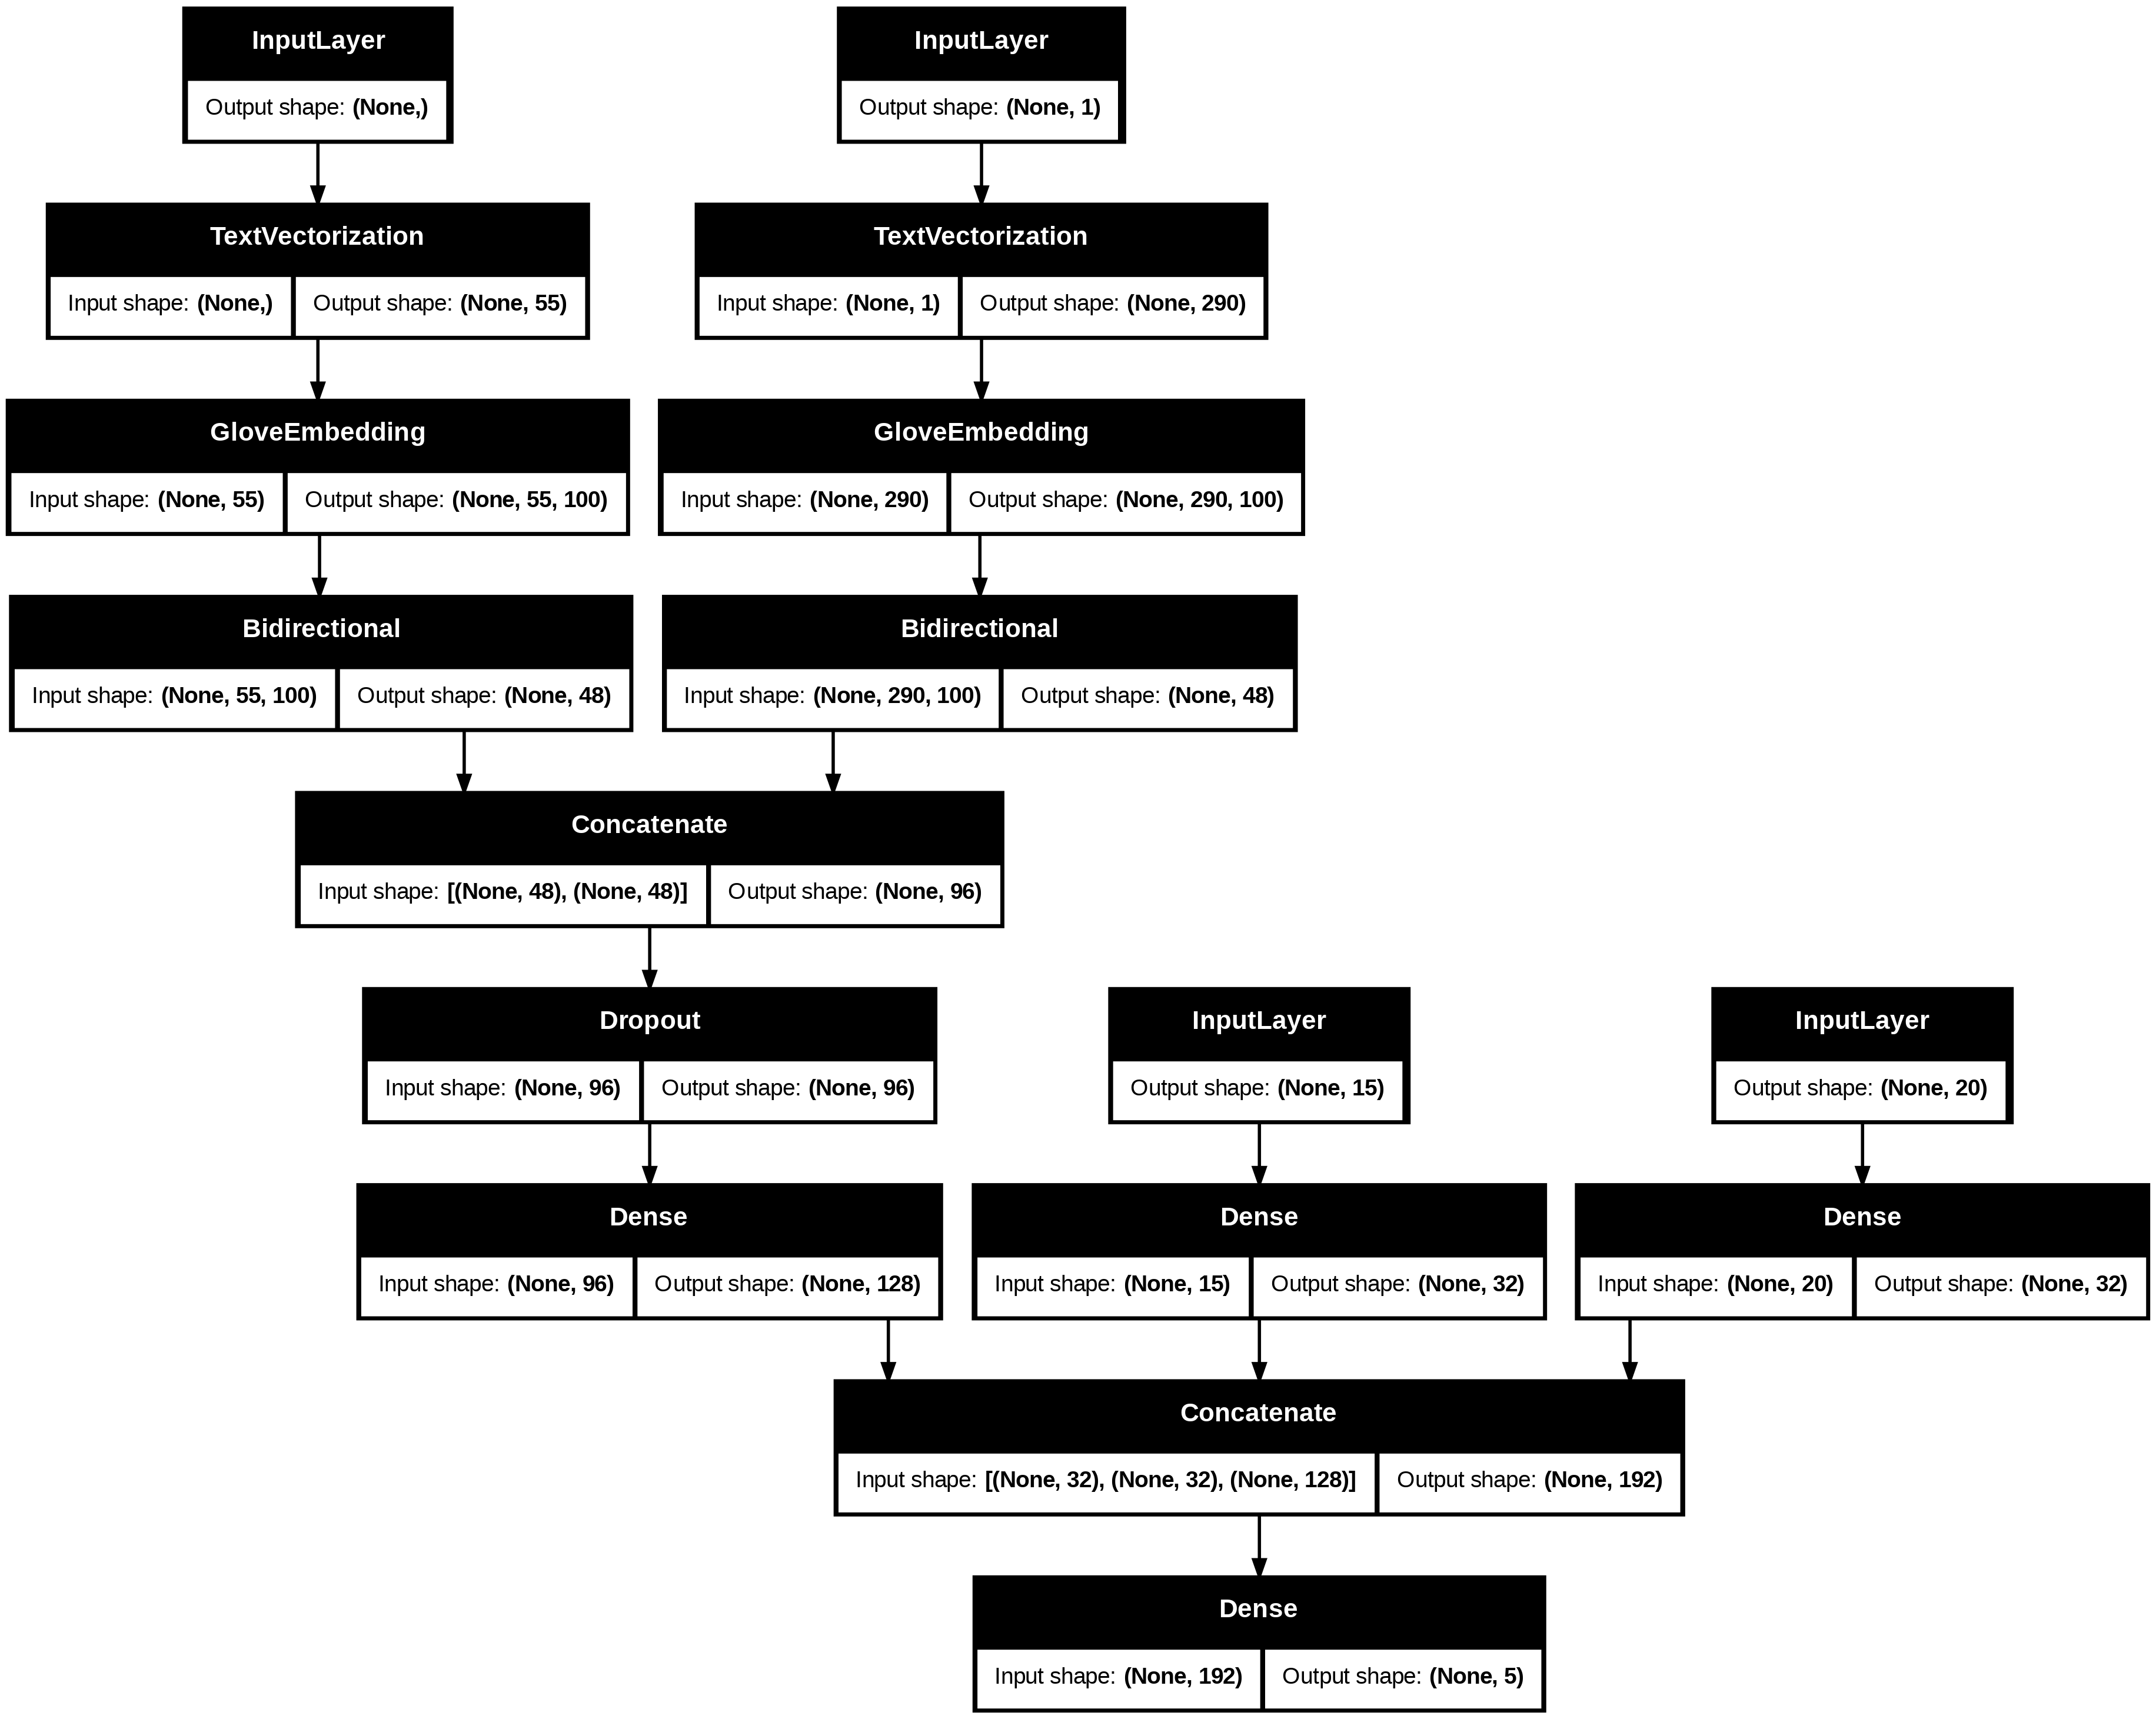

In [72]:
from keras.utils import plot_model
plot_model(model_6, show_shapes=True)

In [73]:
# Create a model checkpoint that:
# monitor: val_loss
# save best only
# only save weights
model_checkpoint_path = "Tribrid_model_Glove.weights.h5"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    model_checkpoint_path,
    monitor = "val_loss",
    save_best_only = True,
    save_weights_only = True,
)

In [74]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience = 3,
)

In [75]:
tf.random.set_seed(42)
mixed_precision.set_global_policy('mixed_float16')

In [ ]:
model_6_history = model_6.fit(
    train_tribrid_dataset, epochs = 50, validation_data = val_tribrid_dataset,
    callbacks = [
        create_tensorboard_callback("Experiments", "Tribrid_model_Glove"),
        model_checkpoint_callback,
        early_stopping_callback
    ]
)

Saving TensorBoard log files to: Experiments/Tribrid_model_Glove/20240827-000223
Epoch 1/50
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 238s 41ms/step - accuracy: 0.5683 - loss: 1.0601 - val_accuracy: 0.8031 - val_loss: 0.5323
Epoch 2/50
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 261s 41ms/step - accuracy: 0.7936 - loss: 0.5484 - val_accuracy: 0.8294 - val_loss: 0.4530
Epoch 3/50
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 232s 41ms/step - accuracy: 0.8207 - loss: 0.4751 - val_accuracy: 0.8423 - val_loss: 0.4195
Epoch 4/50
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 237s 42ms/step - accuracy: 0.8344 - loss: 0.4414 - val_accuracy: 0.8455 - val_loss: 0.4089
Epoch 5/50
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 247s 44ms/step - accuracy: 0.8435 - loss: 0.4201 - val_accuracy: 0.8529 - val_loss: 0.3896
Epoch 6/50
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 254s 42ms/step - accuracy: 0.8500 - loss: 0.4041 - val_accuracy: 0.8564 - val_loss: 0.3807
Epoch 7/50
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 259s 42ms/step - accuracy: 0.8545 - loss: 0.3915 - val_accuracy: 0.8604 - val_l

In [ ]:
model_6.evaluate(val_tribrid_dataset)